# 因果効果推定手法の実装

LaLonde データセットを用いて、因果効果推定の主要な手法を実装・比較する。
- 回帰ベース（OLS）
- 傾向スコアマッチング（PSM）
- 逆確率重み付け（IPW）
- Doubly Robust 推定量

## 分析の構成

1. **真の因果効果（ベンチマーク）**: 実験データ（sample=1, RCT）から計算
2. **観察データでの推定**: treated=1（sample=1）とCPS対照群（sample=2, treated=0）を組み合わせた選択バイアスのあるデータで推定
3. **手法の比較**: 各手法が真の因果効果にどの程度近づけるかを評価

## LaLonde データセットについて

このデータセットは、National Supported Work (NSW) プログラムの効果を分析するために使用されます。

### 変数の定義

- **treated**: 処置変数（1 = 職業訓練プログラムに参加、0 = 非参加）
- **age**: 年齢（歳）
- **educ**: 教育年数（年）
- **black**: 人種ダミー（1 = 黒人、0 = その他）
- **hispan**: ヒスパニック系ダミー（1 = ヒスパニック、0 = その他）
- **married**: 結婚状況（1 = 既婚、0 = 未婚）
- **nodegree**: 学位なしダミー（1 = 高卒資格なし、0 = あり）
- **re74**: 1974年の実質所得（ドル）
- **re75**: 1975年の実質所得（ドル）
- **re78**: 1978年の実質所得（ドル）- アウトカム変数
- **early_ra**: Smith and Todd (2005) の早期ランダム割り当てサンプルへの包含を示す指標変数（実験サンプルに含まれない場合は欠損値）
- **sample**: サンプルの種類（1 = NSW実験サンプル、2 = CPS比較グループ、3 = PSID比較グループ）
- **experimental**: 実験サンプルに含まれるかどうか（1 = 実験サンプル、0 = それ以外）

### サンプルグループの説明

**1. NSW実験サンプル (sample=1)**
- National Supported Work (NSW) プログラムのランダム化比較試験（RCT）データ
- 処置群と対照群がランダムに割り当てられているため、因果効果の推定が容易
- 真の因果効果のベンチマークとして使用される

**2. CPS比較グループ (sample=2)**
- Current Population Survey（米国の雇用統計調査）から抽出された非実験的な対照群
- NSW処置群と比較するために構築された観察データ
- ランダム割り当てではないため、選択バイアスが存在する可能性

**3. PSID比較グループ (sample=3)**
- Panel Study of Income Dynamics（所得動態パネル調査）から抽出された非実験的な対照群
- CPSと同様に、観察データとしてNSW処置群との比較に使用
- より長期的な所得履歴データを含む

LaLonde (1986) とその後の研究では、実験データ（NSW）で得られた因果効果と、観察データ（CPSやPSID）を用いた非実験的手法で得られた推定値を比較することで、各種因果推論手法の妥当性を検証しています。


## 1. データの読み込みと前処理


In [13]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.sandbox.regression.gmm import IV2SLS
import seaborn as sns
import rdrobust
import rddensity

import warnings
warnings.filterwarnings('ignore')

# RDD（回帰不連続デザイン）

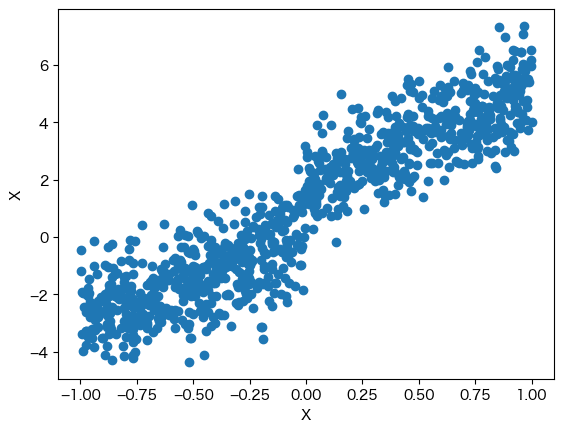

In [2]:
np.random.seed(0)

n = 1000
X = np.random.uniform(-1, 1, size=n)
threshold = 0
treatment = (X > threshold).astype(int)
Y = 3 * X + 2 * treatment + np.random.normal(size=n)

df = pd.DataFrame({
    'Y': Y,
    'X': X,
    'treatment': treatment
})

plt.scatter(df['X'], df['Y'])
plt.xlabel('X')
plt.ylabel('X')
plt.show()

## 連続性の仮定の確認

Text(0, 0.5, 'Number of Observations')

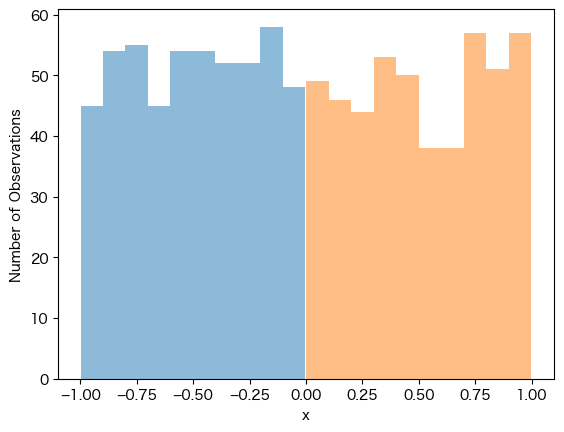

In [3]:
plot_kwargs = {
    'bins': 10,
    'alpha': 0.5,
}
plt.hist(df[df['X'] < threshold]['X'], label='Below Threshold', **plot_kwargs)
plt.hist(df[df['X'] >=  threshold]['X'], label='Above Threshold', **plot_kwargs)
plt.xlabel('x')
plt.ylabel('Number of Observations')

In [4]:
rddensity.rddensity(X, c=0)

Manipulation testing using local polynomial density estimation
Number of obs:                              1000
Model:                              unrestricted
Kernel:                               triangular
BW method:                             estimated
VCE:                                   jackknife

c = 0                               Left of c             Right of c
Number of obs:                            517                    483
Eff. number of obs:                       184                    153
Order est. (p):                             2                      2
Order bias. (q):                            3                      3
BW est.                                0.3446                 0.3336

Method:                                     T                P > |T|
Robust                                  0.963                 0.3356

P-values of binomial tests (H0: p =  [0.5] ).

Window Length/2                           < c                     >= c                    

In [5]:
rdrobust.rdrobust(Y, X, c=0)

Call: rdrobust
Number of Observations:                  1000
Polynomial Order Est. (p):                  1
Polynomial Order Bias (q):                  2
Kernel:                            Triangular
Bandwidth Selection:                    mserd
Var-Cov Estimator:                         NN

                                Left      Right
------------------------------------------------
Number of Observations           517        483
Number of Unique Obs.            517        483
Number of Effective Obs.         112         97
Bandwidth Estimation            0.21       0.21
Bandwidth Bias                 0.362      0.362
rho (h/b)                       0.58       0.58

Method             Coef.     S.E.   t-stat    P>|t|       95% CI      
-------------------------------------------------------------------------
Conventional       1.194    0.304    3.922   8.767e-05     [0.597, 1.791]
Robust                 -        -    3.091   1.994e-03     [0.403, 1.799]


## RDプロット

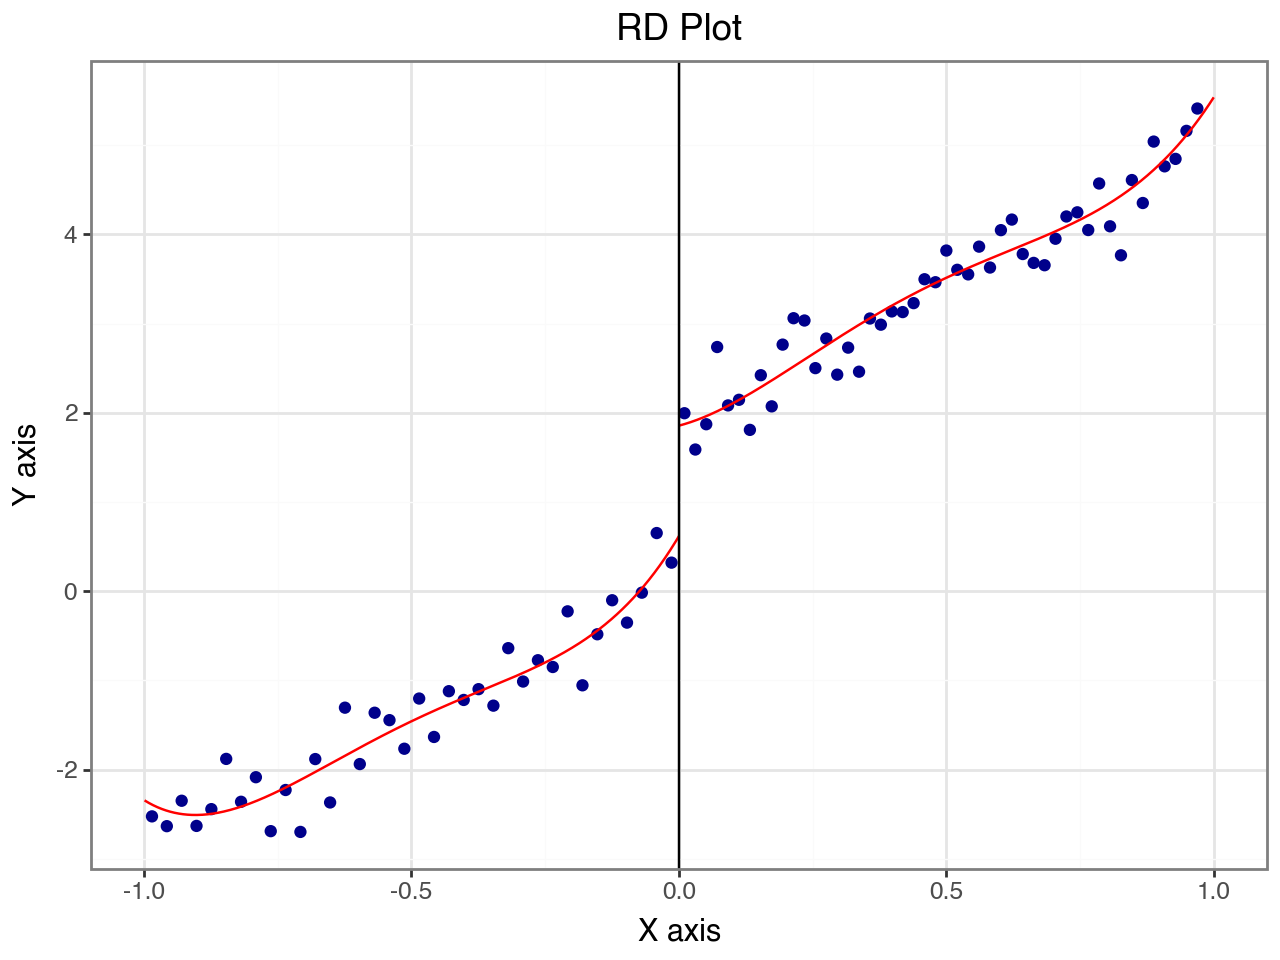

Call: rdplot
Number of Observations:                  1000
Kernel:                               Uniform
Polynomial Order Est. (p):                  4

                                Left      Right
------------------------------------------------
Number of Observations           517        483
Number of Effective Obs          517        483
Bandwith poly. fit (h)         0.999        1.0
Number of bins scale               1          1
Bins Selected                     36         49
Average Bin Length             0.028       0.02
Median Bin Length              0.028       0.02
IMSE-optimal bins               11.0       12.0
Mimicking Variance bins         36.0       49.0

Relative to IMSE-optimal:
Implied scale                  3.273      4.083
WIMSE variance weight          0.028      0.014
WIMSE bias weight              0.972      0.986


In [6]:
rdrobust.rdplot(Y, X, c=0)

## プラセボテスト

In [7]:
rdrobust.rdrobust(Y, X, c=0.5)

Call: rdrobust
Number of Observations:                  1000
Polynomial Order Est. (p):                  1
Polynomial Order Bias (q):                  2
Kernel:                            Triangular
Bandwidth Selection:                    mserd
Var-Cov Estimator:                         NN

                                Left      Right
------------------------------------------------
Number of Observations           759        241
Number of Unique Obs.            759        241
Number of Effective Obs.          85         60
Bandwidth Estimation           0.157      0.157
Bandwidth Bias                 0.251      0.251
rho (h/b)                      0.626      0.626

Method             Coef.     S.E.   t-stat    P>|t|       95% CI      
-------------------------------------------------------------------------
Conventional       0.349    0.392    0.889   3.741e-01     [-0.42, 1.118]
Robust                 -        -    0.883   3.773e-01    [-0.506, 1.337]


# 操作変数法

In [8]:
n = 1000
Z = np.random.normal(size=n)
u = np.random.normal(size=n)
T = Z + np.random.normal(size=n)
Y = T + u

df = pd.DataFrame({
    'Y': Y,
    'T': T,
    'Z' :Z,
    'u': u,
})

Y = df['Y']
T = sm.add_constant(df['Y'])
Z = sm.add_constant(df['Z'])

In [9]:
iv = IV2SLS(Y, T, Z).fit()
print(iv.summary())

                          IV2SLS Regression Results                           
Dep. Variable:                      Y   R-squared:                       1.000
Model:                         IV2SLS   Adj. R-squared:                  1.000
Method:                     Two Stage   F-statistic:                 1.770e+33
                        Least Squares   Prob (F-statistic):               0.00
Date:                Tue, 30 Dec 2025                                         
Time:                        10:20:26                                         
No. Observations:                1000                                         
Df Residuals:                     998                                         
Df Model:                           1                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -5.684e-17   2.45e-17     -2.322      0.0